In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling as pp

from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

import datetime as dt

data is presampled as follows as 5% of the original 2M reviews dateset

df = pd.read_csv('TWITTER_REVIEWS.csv').sample(frac=0.05, replace=False)

df.to_csv('twitter_sample.csv', index=False)

In [24]:
df = pd.read_csv('twitter_sample.csv')

#deleting old index spared in initial dataset
df = df.drop(columns='Unnamed: 0')

df['review_timestamp'] = pd.to_datetime(df.review_timestamp)

df = df.dropna(subset='review_text')

df.head(3)

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,4c3dab6d-6d7e-4aee-92e8-ec2588571ce5,185248414864621136184,A Google user,"First off my account was deactivated,i lost ev...",1,0,NaN,2012-04-07 20:40:56
1,dcde5998-3e52-457a-b5b1-ccdea1b757c0,113742698510423742613,A Google user,Good,5,0,8.11.0-release.00,2020-03-28 04:19:49
2,d37acd68-b810-49f0-aa60-e55f5b06976e,165212703262687555548,A Google user,Good,4,0,NaN,2017-05-15 10:27:47


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104026 entries, 0 to 104242
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   review_id           104026 non-null  object        
 1   pseudo_author_id    104026 non-null  object        
 2   author_name         104026 non-null  object        
 3   review_text         104026 non-null  object        
 4   review_rating       104026 non-null  int64         
 5   review_likes        104026 non-null  int64         
 6   author_app_version  77506 non-null   object        
 7   review_timestamp    104026 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 7.1+ MB


In [26]:
print(df.author_app_version.value_counts())

print("Number of releases {}".format(len(df.author_app_version.value_counts())))

8.25.1-release.01    630
8.92.0-release.00    511
9.98.0-release.0     475
5.39.0               472
8.74.1-release.00    449
                    ... 
7.17.0-beta.679        1
7.41.0-beta.772        1
7.93.3-release.01      1
8.88.0-beta.04         1
9.68.0-release.1       1
Name: author_app_version, Length: 698, dtype: int64
Number of releases 698


In [27]:
df['global_version'] = pd.to_numeric(df.author_app_version.str.split(".").str[0])

set(df.query("global_version.notnull()")['global_version'])

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 100.0}

In [28]:
pp.ProfileReport(df[['author_name', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'global_version']])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

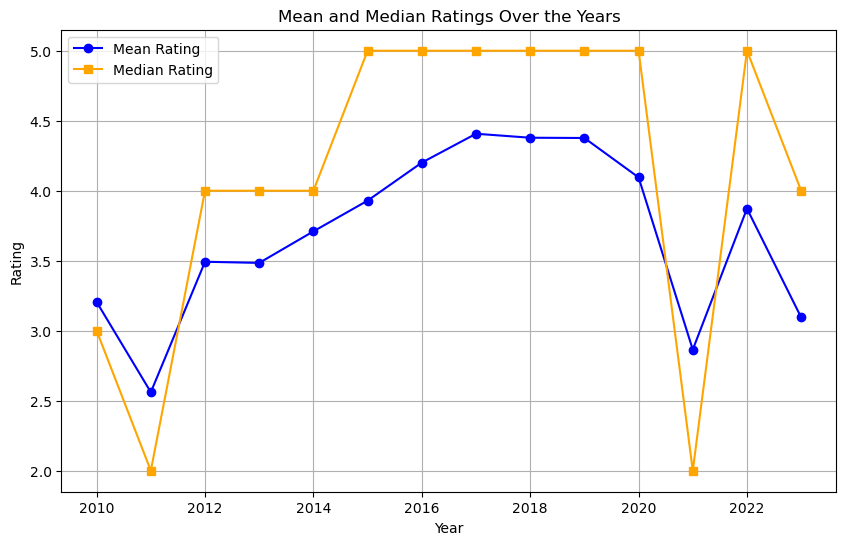

In [29]:
reviews_by_year = df.groupby(df.review_timestamp.dt.year).agg({'review_rating': ['mean', 'median']})

plt.figure(figsize=(10, 6))
plt.plot(reviews_by_year.index, reviews_by_year['review_rating']['mean'], marker='o', label='Mean Rating', color='blue')
plt.plot(reviews_by_year.index, reviews_by_year['review_rating']['median'], marker='s', label='Median Rating', color='orange')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Mean and Median Ratings Over the Years')

plt.legend()

plt.grid(True)

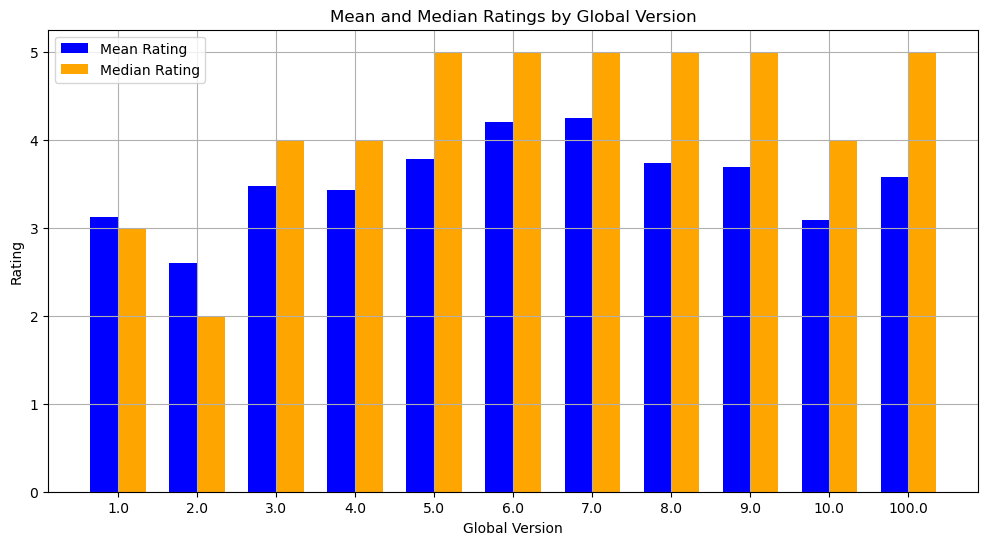

In [30]:
reviews_by_gv = df.groupby(df.global_version).agg({'review_rating': ['mean', 'median']})

# Creating a bar plot for mean and median ratings
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
bar_positions = range(len(reviews_by_gv))

#mean
ax.bar(bar_positions, reviews_by_gv['review_rating']['mean'], width=bar_width, label='Mean Rating', color='blue')
#median
ax.bar([pos + bar_width for pos in bar_positions], reviews_by_gv['review_rating']['median'],
       width=bar_width, label='Median Rating', color='orange')

#labels
ax.set_xlabel('Global Version')
ax.set_ylabel('Rating')
ax.set_title('Mean and Median Ratings by Global Version')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(reviews_by_gv.index)
ax.legend()

ax.grid(True)


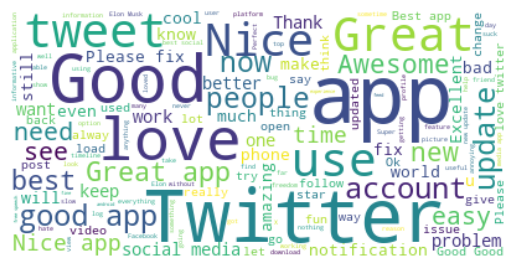

In [31]:
text_for_cloud = ' '.join(df['review_text'].dropna())

# cloud
cloud = WordCloud(background_color='white').generate(text_for_cloud)
 
# displaying
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")

In [32]:
#tokens
word_tokens = [word_tokenize(line) for line in df['review_text']]

len_tokens = []

# filling up a list with the numbers of the tokens
for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

# adding to df
df['n_words'] = len_tokens

Text(0.5, 1.0, 'Distribution of Word Counts in Reviews')

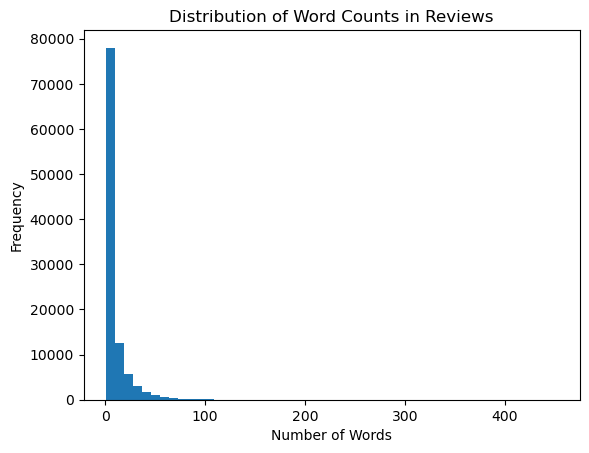

In [39]:
plt.hist(df['n_words'], bins=50)

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reviews')